In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from detector.detector import *
from simulator.utils import *
from preprocessing.deconvolution import *
from preprocessing.autoencoders import *



Create Data and Labels
-----------------

In [2]:
img_size = 100
exposure_time = 1
sim = simulator(img_size, exposure_time)

# creates Gaussian signals
def create_signal(img_size, x0, y0):      
    signals = [] 
    
    for i in range(x0.shape[0]):
        x = y = np.linspace(0, img_size-1, img_size)
        xgrid, ygrid = np.meshgrid(x, y)  
        signal = gaussian(xgrid, ygrid, x0[i], y0[i], simulator.variance)
        signals.append(signal)
    
    signals = np.array(signals)
    return np.sum(signals, axis=0)


def create_rand_pos(img_size, atom_count):
    x0 = np.random.rand(atom_count) * img_size
    y0 = np.random.rand(atom_count) * img_size
    x0 = x0.astype(np.int)
    y0 = y0.astype(np.int)

    return x0, y0


# make N data pairs with defined SNR. The number of atoms, the positions are random
def make_data(img_size, N, SNR):
    data = []
    labels = []

    # rand generator for no_atom
    # no_atom_arr = np.random.choice([True, False], size=(N,))

    # for atom count
    atom_count_arr = np.random.choice([1,2,3,4,5,6,7,8,9], size=(N,))
    # print(atom_count_arr)
    # for x0, y0 
    for atom_count in atom_count_arr:
        x0, y0 = create_rand_pos(img_size, atom_count)
        noisy_data = sim.create_simulation_from_SNR(x0, y0, SNR, no_atom=False)
        noisy_data = noisy_data / np.max(noisy_data) 
        data.append(noisy_data)

        clean_data = create_signal(img_size, x0, y0)
        clean_data = clean_data / np.max(clean_data)
        labels.append(clean_data)

    data = np.array(data)
    labels = np.array(labels)
    data = np.expand_dims(data, axis=3)
    labels = np.expand_dims(labels, axis=3)
    return data, labels


def make_data_at_center(img_size, N, SNR):
    data = []
    labels = []

    for i in range(N):
        x0, y0 = np.array([img_size//2]), np.array([img_size//2])
        noisy_data = sim.create_simulation_from_SNR(x0, y0, SNR, no_atom=False)
        noisy_data = noisy_data / np.max(noisy_data) 
        data.append(noisy_data)

        clean_data = create_signal(img_size, x0, y0)
        clean_data = clean_data / np.max(clean_data)
        labels.append(clean_data)
    data = np.array(data)
    labels = np.array(labels)
    data = np.expand_dims(data, axis=3)
    labels = np.expand_dims(labels, axis=3)

    return data, labels



In [3]:
centered_data_tr, centered_labels_tr = make_data_at_center(100, 2000, 10)
centered_data_val, centered_labels_val = make_data_at_center(100, int(2000*0.3), 10)
centered_data_tr.shape

(2000, 100, 100, 1)

In [4]:
data_tr, labels_tr = make_data(100, 10000, 10)
data_val, labels_val = make_data(100, int(10000*0.3), 10)
data_tr.shape

(10000, 100, 100, 1)

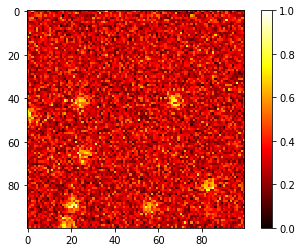

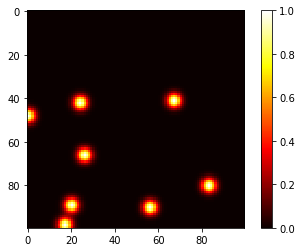

In [5]:
plt.imshow(data_tr[0, :, :, 0], cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(labels_tr[0, :, :, 0], cmap='hot')
plt.colorbar()
plt.show()

Dense Model
-----------------
(1000, 500, 1000, 10000)

Training on data with centered atoms:
----------------------------

In [23]:
dm1 = dense_model()
dm1.compile(optimizer='adam', loss='mse')
# print(dense_model.summary())

In [24]:
dm1.fit(centered_data_tr, centered_labels_tr,
                epochs=4,
                batch_size=128,
                shuffle=True,
                validation_data=(centered_data_val, centered_labels_val))

Train on 2000 samples, validate on 600 samples
Epoch 1/4
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.0537 - val_loss: 8.2501e-04
Epoch 2/4
2000/2000 [==============================] - 3s 2ms/sample - loss: 8.1593e-04 - val_loss: 8.1262e-04
Epoch 3/4
2000/2000 [==============================] - 3s 2ms/sample - loss: 8.1355e-04 - val_loss: 8.1262e-04
Epoch 4/4
2000/2000 [==============================] - 3s 2ms/sample - loss: 8.1262e-04 - val_loss: 8.1262e-04


In [25]:
print(dm1.summary()) 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  10001000  
_________________________________________________________________
dense_13 (Dense)             multiple                  500500    
_________________________________________________________________
dense_14 (Dense)             multiple                  501000    
_________________________________________________________________
dense_15 (Dense)             multiple                  10010000  
_________________________________________________________________
reshape_3 (Reshape)          multiple                  0         
Total params: 21,012,500
Trainable params: 21,012,500
Non-trainable params: 0
__________________________________________

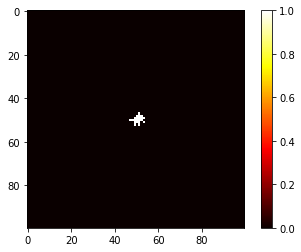

In [26]:
idx = 0
data_pred = dm1.predict(centered_data_tr[idx:idx+1, :, :, 0:1])[0]
plt.imshow(data_pred, cmap='hot')
plt.colorbar()

Training on Data with Randomly Distributed Atoms
-----------------------------------

In [27]:
dm2 = dense_model()
dm2.compile(optimizer='adam', loss='mse')


In [28]:
dm2.fit(data_tr, labels_tr,
                epochs=4,
                batch_size=128,
                shuffle=True,
                validation_data=(data_val, labels_val))

Train on 10000 samples, validate on 3000 samples
Epoch 1/4
10000/10000 [==============================] - 17s 2ms/sample - loss: 0.0147 - val_loss: 0.0071
Epoch 2/4
10000/10000 [==============================] - 18s 2ms/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 3/4
10000/10000 [==============================] - 19s 2ms/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 4/4
10000/10000 [==============================] - 19s 2ms/sample - loss: 0.0073 - val_loss: 0.0071


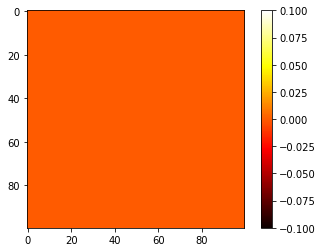

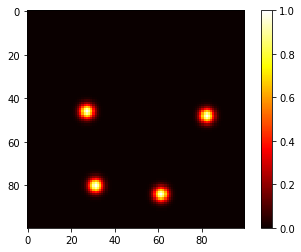

In [31]:
idx = 0
data_pred = dm2.predict(data_tr[idx:idx+1, :, :, 0:1])[0]
plt.imshow(data_pred, cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(labels_tr[idx, :, :, 0], cmap='hot')
plt.colorbar()
plt.show()

Deeper Dense Net 
--------------------
(8000, 4000, 2000, 1000, 500, 1000, 2000, 3000, 4000, 8000, 10000)
training on the random atoms data set

In [6]:
dm_deeper = dense_model2()
dm_deeper.compile('adam', loss='mse')


In [7]:
dm_deeper.fit(centered_data_tr, centered_labels_tr,
                epochs=6,
                batch_size=128,
                shuffle=True,
                validation_data=(centered_data_val, centered_labels_val))

Train on 2000 samples, validate on 600 samples
Epoch 1/6
2000/2000 [==============================] - 38s 19ms/sample - loss: 0.0488 - val_loss: 0.0015
Epoch 2/6
2000/2000 [==============================] - 37s 18ms/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 3/6
2000/2000 [==============================] - 98s 49ms/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 4/6
2000/2000 [==============================] - 111s 55ms/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 5/6
2000/2000 [==============================] - 110s 55ms/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 6/6
2000/2000 [==============================] - 108s 54ms/sample - loss: 0.0017 - val_loss: 0.0017


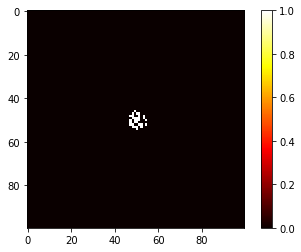

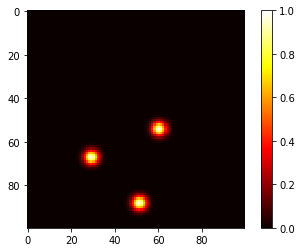

In [42]:
idx = 90
data_pred = dm_deeper.predict(data_tr[idx:idx+1, :, :, 0:1])[0]
plt.imshow(data_pred, cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(labels_tr[idx, :, :, 0], cmap='hot')
plt.colorbar()
plt.show()

CNN for Centered Atoms
-------------------

In [8]:
cnn = conv_and_upsampling_model()
cnn.compile(optimizer='adam', loss='mse')


In [9]:
cnn.fit(centered_data_tr, centered_labels_tr,
                epochs=6,
                batch_size=128,
                shuffle=True,
                validation_data=(centered_data_val, centered_labels_val))

Train on 2000 samples, validate on 600 samples
Epoch 1/6
2000/2000 [==============================] - 30s 15ms/sample - loss: 0.0998 - val_loss: 0.0016
Epoch 2/6
2000/2000 [==============================] - 31s 15ms/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 3/6
2000/2000 [==============================] - 31s 15ms/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 4/6
2000/2000 [==============================] - 25s 13ms/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 5/6
2000/2000 [==============================] - 26s 13ms/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 6/6
2000/2000 [==============================] - 26s 13ms/sample - loss: 0.0016 - val_loss: 0.0016


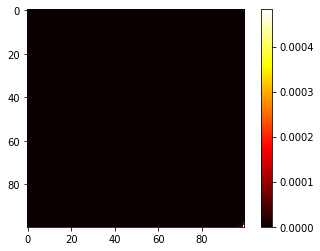

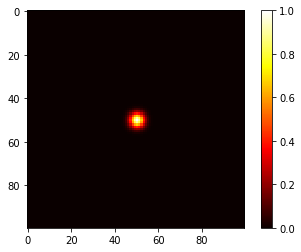

In [10]:
idx = 90
data_pred = cnn.predict(centered_data_tr[idx:idx+1, :, :, 0:1])[0,:,:,0]
plt.imshow(data_pred, cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(centered_labels_tr[idx, :, :, 0], cmap='hot')
plt.colorbar()
plt.show()

In [14]:
dense_model.predict(data_tr[1:2, :, :, 0:1]).shape

(1, 100, 100)

In [12]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)       

In [30]:
def conv_and_upsampling_model2():

    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', input_shape=(100, 100, 1)))
    # model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
    # model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1000, activation='relu'))
    model.add(keras.layers.Dense(500, activation='relu'))
    model.add(keras.layers.Dense(1000, activation='relu'))
    model.add(keras.layers.Dense(8000, activation='relu'))
    model.add(keras.layers.Reshape((50, 50, 32)))

    model.add(keras.layers.UpSampling2D(size=(2, 2)))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
    # model.add(keras.layers.UpSampling2D(size=(2,2)))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
    # model.add(keras.layers.UpSampling2D(size=(2,2)))
    model.add(keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'))
    # model.add(keras.layers.UpSampling2D(size=(2,2)))

    # model.add(keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='relu'))
    model.add(keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

    return model

In [31]:
cnn2 = conv_and_upsampling_model2()
cnn2.compile(optimizer='adam', loss='mse')


In [32]:
cnn2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 100, 100, 8)       80        
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 100, 100, 16)      1168      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1000)              80001000  
_________________________________________________________________
dense_24 (Dense)             (None, 500)              

In [34]:
cnn2.fit(centered_data_tr, centered_labels_tr,
                epochs=6,
                batch_size=128,
                shuffle=True,
                validation_data=(centered_data_val, centered_labels_val))

Train on 2000 samples, validate on 600 samples
Epoch 1/6
 128/2000 [>.............................] - ETA: 28s

InvalidArgumentError:  Input to reshape is a tensor with 1024000 values, but the requested shape has 10240000
	 [[node sequential_6/reshape_5/Reshape (defined at <ipython-input-34-3a68d413766e>:5) ]] [Op:__inference_distributed_function_6879]

Function call stack:
distributed_function


In [ ]:
idx = 90
data_pred = cnn.predict(centered_data_tr[idx:idx+1, :, :, 0:1])[0,:,:,0]
plt.imshow(data_pred, cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(centered_labels_tr[idx, :, :, 0], cmap='hot')
plt.colorbar()
plt.show()

In [17]:
centered_data_tr.shape

(2000, 100, 100, 1)